## Element-wise operations

The __relu__ operation and addition are __element-wise__ operations: operations that are applied independently to each entry in the tensors being considered.This means these operations are highly amenable to massively parallel implementations (vectorized
implementations, a term that comes from the vector processor supercomputer architecture from the 1970–1990 period).

If you want to write a naive Python implementation of an element-wise operation, you use a __for__ loop, as in this naive
implementation of an element-wise __relu__ operation :

In [1]:
def naive_relu(x):
    # x is a 2D Numpy tensor.
    assert len(x.shape) == 2
    
    # Avoid overwriting the input tensor.
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

You do the same for __addition__:

In [2]:
def naive_add(x, y):
    # x and y are 2D Numpy tensors.
    assert len(x.shape) == 2
    assert x.shape == y.shape
    
    # Avoid overwriting the input tensor.
    x = x.copy()
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In practice, when dealing with Numpy arrays, these operations are available as welloptimized built-in Numpy functions, which themselves delegate the heavy lifting to a Basic Linear Algebra Subprograms (BLAS) implementation if you have one installed (which you should). BLAS are low-level, highly parallel, efficient tensor-manipulation routines that are typically implemented in Fortran or C. So, in Numpy, you can do the following element-wise operation, and it will be blazing fast:

In [3]:
import numpy as np
x, y, z = 0., 0., 0.
z = x + y # Element-wise addition
z = np.maximum(z, 0.) # Element-wise relu

## Broadcasting

Our earlier naive implementation of __naive_add__ only supports the addition of 2D tensors with identical shapes. But in the __Dense__ layer introduced earlier, we added a 2D tensor with a vector. What happens with addition when the shapes of the two tensors being added differ?

When possible, and if there’s no ambiguity, the smaller tensor will be __broadcasted__ to match the shape of the larger tensor. Broadcasting consists of two steps:

1. Axes (called __broadcast axes__) are added to the smaller tensor to match the _ndim_ of the larger tensor.
2. The smaller tensor is repeated alongside these new axes to match the full shape of the larger tensor.

Let’s look at a concrete example. Consider X with shape (32, 10) and y with shape (10,). First, we add an empty first axis to y, whose shape becomes (1, 10). Then, we repeat y 32 times alongside this new axis, so that we end up with a tensor Y with shape (32, 10), where Y[i, :] == y for i in range(0, 32). At this point, we can proceed to add X and Y, because they have the same shape.

In terms of implementation, no new 2D tensor is created, because that would be terribly inefficient. The repetition operation is entirely virtual: it happens at the algorithmic level rather than at the memory level. But thinking of the vector being repeated 10 times alongside a new axis is a helpful mental model. Here’s what a naive implementation would look like:

In [4]:
def naive_add_matrix_and_vector(x, y):
    # x is a 2D Numpy tensor.
    assert len(x.shape) == 2
    # y is a Numpy vector.
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    
    # Avoid overwriting the input tensor.
    x = x.copy()
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

With broadcasting, you can generally apply two-tensor element-wise operations if one tensor has shape _(a, b, … n, n + 1, … m)_ and the other has shape _(n, n + 1, … m)_. The broadcasting will then automatically happen for axes a through _n - 1_. The following example applies the element-wise __maximum__ operation to two tensors of different shapes via broadcasting:

In [5]:
import numpy as np
# x is a random tensor with shape (2, 3, 2, 2).
x = np.zeros((2, 3, 2, 2))
# y is a random tensor with shape (2, 2).
y = np.random.random((2, 2))
# The output z has shape (2, 3, 2, 2) like x.
z = np.maximum(x, y)

In [6]:
x

In [7]:
y

In [8]:
z

## Tensor dot

The dot operation, also called a __tensor product__ (not to be confused with an elementwise product) is the most common, most useful tensor operation. Contrary to element-wise operations, it combines entries in the input tensors. An element-wise product is done with the * operator in Numpy, Keras, Theano, and TensorFlow. _dot_ uses a different syntax in TensorFlow, but in both Numpy and Keras it’s done using the standard _dot_ operator:

In [9]:
import numpy as np
z = np.dot(x, y)

In mathematical notation, you’d note the operation with a dot (.):

z = x . y

Mathematically, what does the dot operation do? Let’s start with the dot product of two vectors x and y. It’s computed as follows:

In [10]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    
    z = 0.
    
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    
    return z

You’ll have noticed that the dot product between two vectors is a scalar and that only vectors with the same number of elements are compatible for a dot product. You can also take the dot product between a matrix x and a vector y, which returns a vector where the coefficients are the dot products between y and the rows of x. You implement it as follows:

In [11]:
import numpy as np

def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    
    z = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    
    return z

You could also reuse the code we wrote previously, which highlights the relationship between a matrix-vector product and a vector product:

In [12]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

Note that as soon as one of the two tensors has an _ndim_ greater than 1, _dot_ is no longer symmetric, which is to say that _dot(x, y)_ isn’t the same as _dot(y, x)_.

Of course, a dot product generalizes to tensors with an arbitrary number of axes. The most common applications may be the dot product between two matrices. You can take the dot product of two matrices x and y (dot(x, y)) if and only if x.shape[1] == y.shape[0]. The result is a matrix with shape (x.shape[0], y.shape[1]), where the coefficients are the vector products between the rows of x and the columns of y. Here’s the naive implementation:

In [13]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    
    z = np.zeros((x.shape[0], y.shape[1]))
    
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

To understand dot-product shape compatibility, it helps to visualize the input and output tensors by aligning them as shown in figure below :

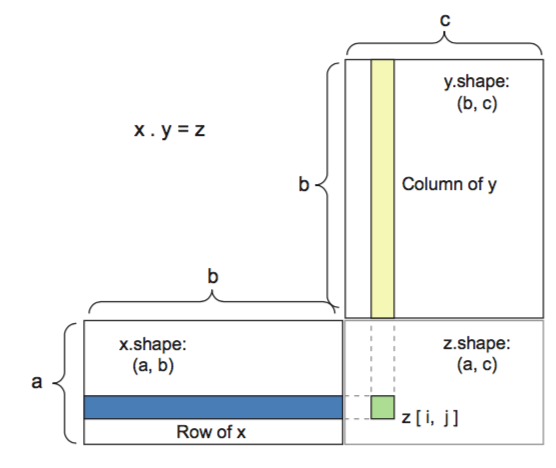

x, y, and z are pictured as rectangles (literal boxes of coefficients). Because the rows of x and the columns of y must have the same size, it follows that the width of x must match the height of y. If you go on to develop new machine-learning algorithms, you’ll likely be drawing such diagrams often.
More generally, you can take the dot product between higher-dimensional tensors, following the same rules for shape compatibility as outlined earlier for the 2D case:

(a, b, c, d) . (d,) -> (a, b, c)

(a, b, c, d) . (d, e) -> (a, b, c, e)

And so on.

## Tensor reshaping

Reshaping a tensor means rearranging its rows and columns to match a target shape. Naturally, the reshaped tensor has the same total number of coefficients as the initial
tensor. Reshaping is best understood via simple examples:

In [14]:
x = np.array([[0., 1.],
[2., 3.],
[4., 5.]])

In [15]:
print(x.shape)

In [16]:
x = x.reshape((6, 1))

In [17]:
x

In [18]:
x = x.reshape((2, 3))

In [19]:
x

A special case of reshaping that’s commonly encountered is __transposition__. __Transposing__ a
matrix means exchanging its rows and its columns, so that x[i, :] becomes x[:, i]:

In [20]:
x = np.zeros((300, 20))
x = np.transpose(x)
print(x.shape)